In [18]:
import pandas as pd
import numpy as np
import pandas_ta as ta  # ติดตั้งด้วย: pip install pandas-ta
from cassandra.cluster import Cluster
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Section 1: การเตรียมข้อมูล (Data Extraction & Features)


In [19]:
# 1.1 ดึงข้อมูล
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('stock_data')

In [ ]:
# 1.1 ดึงข้อมูล
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('stock_data')
query = "SELECT symbol, date, open, high, low, close, volume FROM candlestick_data WHERE symbol = 'BANPU' ALLOW FILTERING"
df = pd.DataFrame(list(session.execute(query)))

In [ ]:
# 1.2 เตรียม Data และ RSI    
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df['rsi'] = ta.rsi(df['close'], length=14)
df = df.dropna().reset_index(drop=True)
df.head()

,symbol,date,open,high,low,close,volume,rsi
0,3BBIF,2023-01-17,8.25,8.25,8.2,8.25,2057675,74.999940
1,3BBIF,2023-01-18,8.25,8.25,8.2,8.20,2744544,66.101624
2,3BBIF,2023-01-19,8.20,8.25,8.2,8.25,3241312,69.942141
3,3BBIF,2023-01-20,8.25,8.25,8.2,8.25,5704673,69.942141
4,3BBIF,2023-01-23,8.25,8.25,8.2,8.25,3773944,69.942141


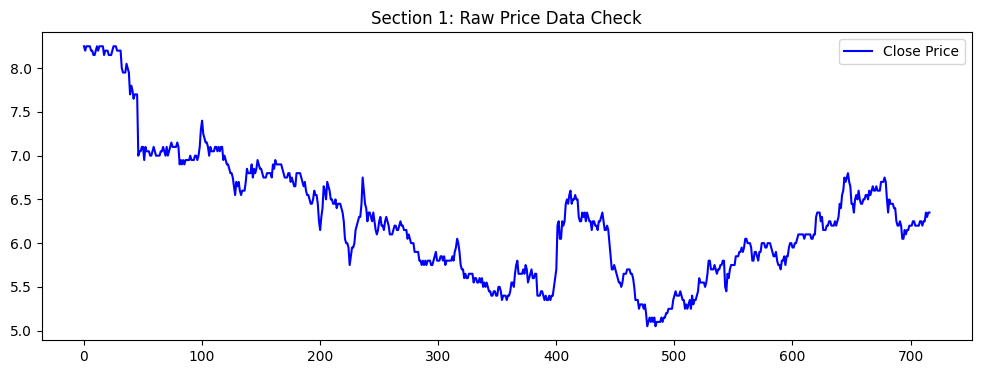

In [22]:
# 1.3 พล็อตกราฟเช็คข้อมูลดิบ
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(df['close'], label='Close Price', color='blue')
ax1.set_title('Section 1: Raw Price Data Check')
plt.legend()
plt.show()

## Section 2: การทำ Labeling (The Ground Truth)


In [23]:
from scipy.signal import find_peaks
def apply_labels(df):
    df['target'] = 0
    close = df['close'].values
    
    # หาจุดสูงสุด (Peaks) โดยใช้ความผันผวน (Std) เป็นเกณฑ์ความสูง
    peaks, _ = find_peaks(close, distance=10, prominence=close.std() * 0.2)
    
    for i in range(len(peaks) - 2):
        p1, p2, p3 = peaks[i], peaks[i+1], peaks[i+2]
        
        # เงื่อนไข H&S: ยอดกลาง (Head) สูงกว่าไหล่สองข้าง
        if close[p2] > close[p1] and close[p2] > close[p3]:
            # ไหล่สองข้างสูงใกล้เคียงกัน (ต่างกันไม่เกิน 15%)
            shoulder_diff = abs(close[p1] - close[p3]) / max(close[p1], close[p3])
            
            if shoulder_diff < 0.15:
                # ทำ Label ที่จุดจบของไหล่ขวา (p3) เพราะเป็นจุดที่เข้าเทรดได้จริง
                df.at[p3, 'target'] = 1
                
    print(f"พบรูปแบบ H&S ทั้งหมด: {df['target'].sum()} จุด")
    return df

df = apply_labels(df)


พบรูปแบบ H&S ทั้งหมด: 6 จุด


## Section 3: การสร้าง Tensors (Input Preparation)


In [24]:
def prepare_tensors(df, window_size=50):
    features, labels = [], []
    data_matrix = df[['open', 'high', 'low', 'close', 'volume', 'rsi']].values
    
    pos_idx = df[df['target'] == 1].index.values
    neg_idx = df[df['target'] == 0].index.values
    
    # สุ่มข้อมูล Negative 3 เท่าของ Positive
    sel_neg = np.random.choice(neg_idx[neg_idx > window_size], len(pos_idx)*3, replace=False)
    indices = np.concatenate([pos_idx, sel_neg])
    all_labels = np.concatenate([np.ones(len(pos_idx)), np.zeros(len(sel_neg))])

    for i, idx in enumerate(indices):
        window = data_matrix[idx-window_size : idx].copy()
        w_min, w_max = window.min(axis=0), window.max(axis=0)
        features.append((window - w_min) / (w_max - w_min + 1e-9))
        labels.append(all_labels[i])
        
    return np.array(features), np.array(labels)

X, y = prepare_tensors(df)



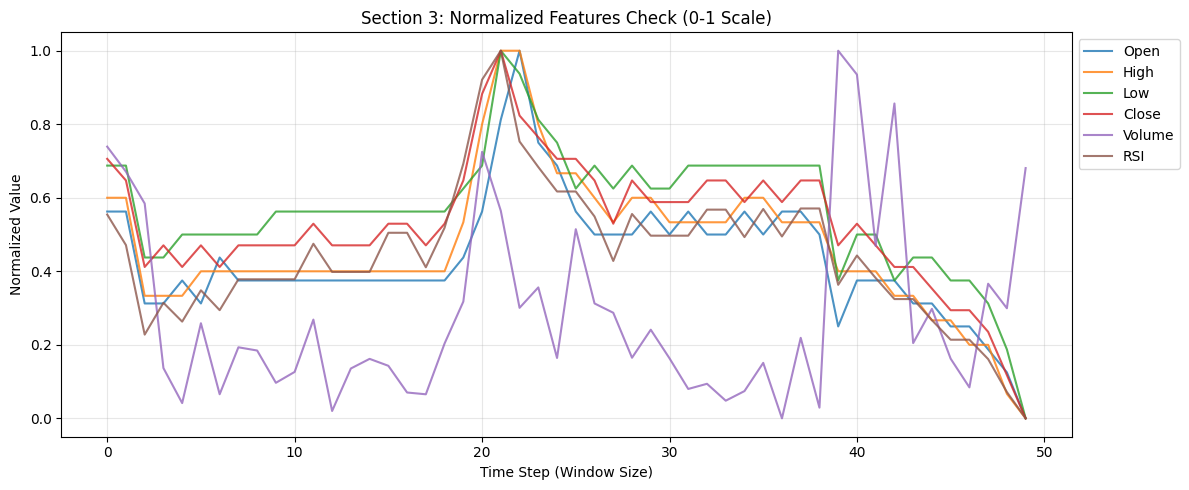

In [25]:
# 3.1 พล็อตกราฟเช็คความถูกต้องของ Features (AI's Input View)
plt.figure(figsize=(12, 5))

# รายชื่อ Feature ตามลำดับใน data_matrix (open, high, low, close, volume, rsi)
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI']

# พล็อตข้อมูลใน Window แรก (X[0])
for i in range(len(feature_names)):
    plt.plot(X[0][:, i], label=feature_names[i], alpha=0.8)

plt.title('Section 3: Normalized Features Check (0-1 Scale)')
plt.xlabel('Time Step (Window Size)')
plt.ylabel('Normalized Value')

# เพิ่ม Legend เพื่อระบุว่าเส้นไหนคืออะไร
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 

plt.grid(True, alpha=0.3)
plt.tight_layout() # เพื่อไม่ให้กราฟทับ Legend
plt.show()

## Section 4: การสร้างและฝึกโมเดล (Deep Learning)

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(50, 6)),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)


Epoch 1/30


/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2632 - loss: 0.7021 - val_accuracy: 0.8000 - val_loss: 0.6810
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7895 - loss: 0.6789 - val_accuracy: 0.8000 - val_loss: 0.6634
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7368 - loss: 0.6640 - val_accuracy: 0.8000 - val_loss: 0.6475
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7368 - loss: 0.6501 - val_accuracy: 0.8000 - val_loss: 0.6324
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7368 - loss: 0.6346 - val_accuracy: 0.8000 - val_loss: 0.6176
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7368 - loss: 0.6263 - val_accuracy: 0.8000 - val_loss: 0.6022
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7368 - loss: 0.6169 - val_accuracy: 0.8000 - val_loss: 0.5872
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7368 - loss: 0.6007 - val_accuracy: 0.8000 - val_loss: 0.5728
Epoch 9/30
1


--- Model Evaluation Results ---
Final Training Accuracy:   0.7368
Final Validation Accuracy: 0.8000
Final Validation Loss:     0.5412


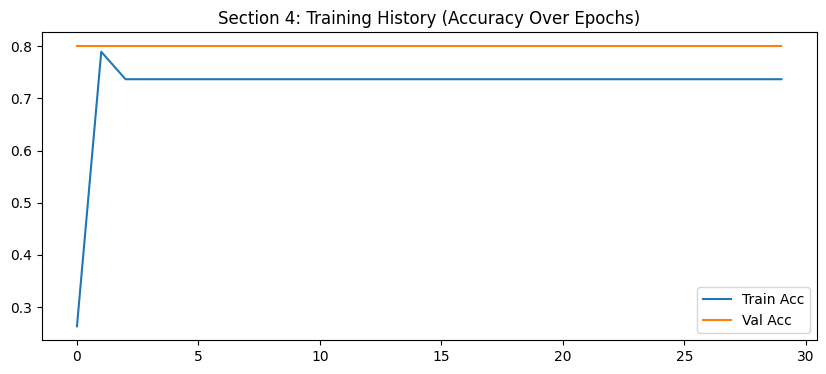

In [27]:
# 4.1 พล็อตกราฟผลการ Train (Learning Curves)
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n--- Model Evaluation Results ---")
print(f"Final Training Accuracy:   {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Validation Loss:     {final_val_loss:.4f}")

# 4.2 แสดงค่า Accuracy และ Loss จากรอบสุดท้ายของการ Training

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Section 4: Training History (Accuracy Over Epochs)')
plt.legend()
plt.show()


## Section 5: การประเมินผลความแม่นยำ (Evaluation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


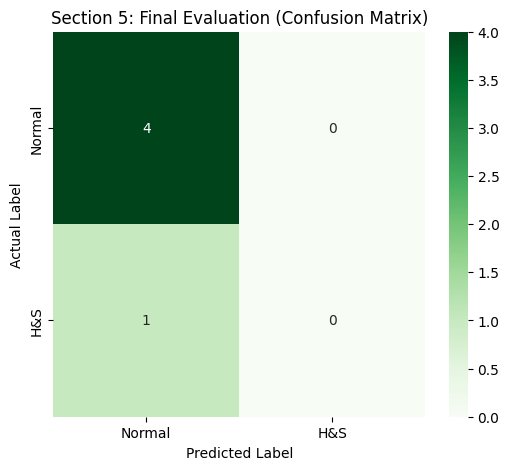


--- สรุปผลจาก Confusion Matrix ---
TP (ทายถูก H&S): 0 | FP (ทายผิด H&S): 0
FN (พลาด H&S): 1 | TN (ทายถูก Normal): 4
---------------------------------
วิเคราะห์: โมเดลยังไม่สามารถตรวจจับรูปแบบ H&S ได้ถูกต้องเลย


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal', 'H&S'], 
            yticklabels=['Normal', 'H&S'])
plt.title('Section 5: Final Evaluation (Confusion Matrix)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print Summary
print("\n--- สรุปผลจาก Confusion Matrix ---")
print(f"TP (ทายถูก H&S): {tp} | FP (ทายผิด H&S): {fp}")
print(f"FN (พลาด H&S): {fn} | TN (ทายถูก Normal): {tn}")
print("---------------------------------")
if tp == 0:
    print("วิเคราะห์: โมเดลยังไม่สามารถตรวจจับรูปแบบ H&S ได้ถูกต้องเลย")
elif fp > tp:
    print("วิเคราะห์: โมเดลมี False Alarm สูง ควรระวังการเข้าเทรด")
else:
    print("วิเคราะห์: โมเดลเริ่มมีประสิทธิภาพในการตรวจจับ H&S")



## Section 6: การทดสอบตรวจจับบนกราฟจริง (Visual Inference)

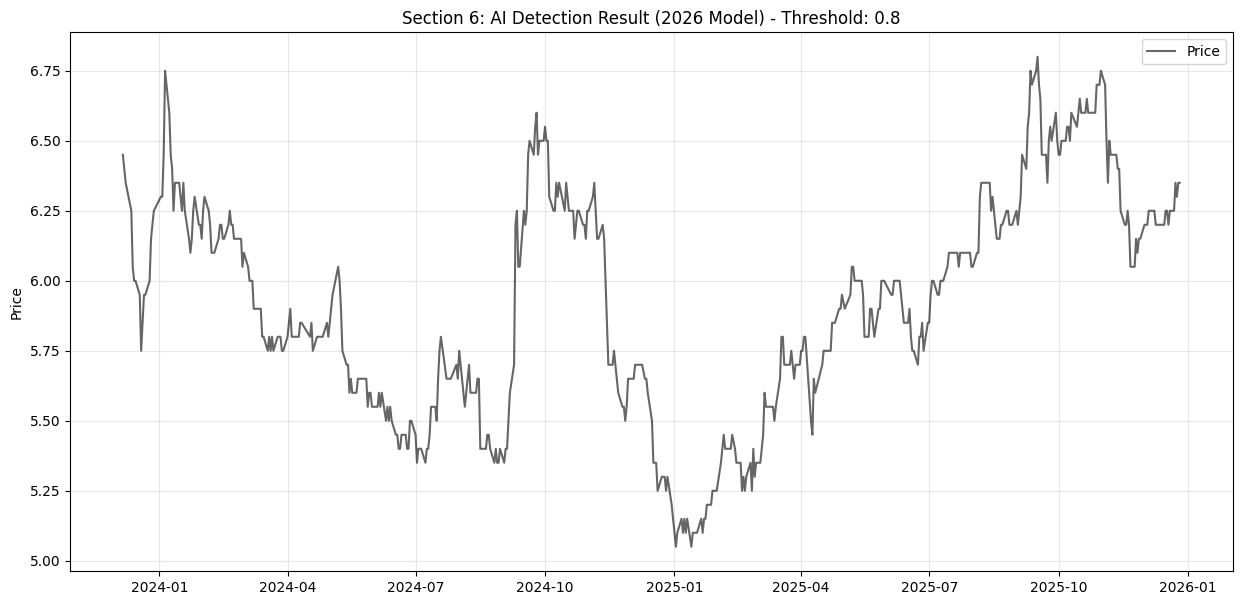

In [29]:
def visualize_predictions(df, model, window_size=50, threshold=0.8):
    """
    df: DataFrame ข้อมูลหุ้น
    threshold: ค่าความมั่นใจ (0-1) ที่จะให้ถือว่าเป็น H&S
    """
    close_prices = df['close'].values
    data_matrix = df[['open', 'high', 'low', 'close', 'volume', 'rsi']].values
    predictions = np.zeros(len(df))
    
    # สแกนโมเดลไปตามกราฟ (Sliding Window)
    for i in range(window_size, len(df)):
        window = data_matrix[i-window_size:i].copy()
        # Normalization เหมือนตอน Train
        w_min, w_max = window.min(axis=0), window.max(axis=0)
        window_norm = (window - w_min) / (w_max - w_min + 1e-9)
        
        # ให้โมเดลทำนาย
        prob = model.predict(window_norm.reshape(1, window_size, 6), verbose=0)[0][0]
        if prob > threshold:
            predictions[i] = prob

    # พล็อตกราฟผลลัพธ์
    plt.figure(figsize=(15, 7))
    plt.plot(df['date'], df['close'], label='Price', color='black', alpha=0.6)
    
    # มาร์คจุดที่ AI ตรวจพบ
    detected_indices = np.where(predictions > 0)[0]
    for idx in detected_indices:
        plt.scatter(df.iloc[idx]['date'], df.iloc[idx]['close'], 
                    color='red', s=100, label='H&S Detected' if idx == detected_indices[0] else "")
        # แสดงค่าความมั่นใจ (Confidence Score)
        plt.text(df.iloc[idx]['date'], df.iloc[idx]['close']*1.02, 
                 f"{predictions[idx]:.2f}", color='red', fontsize=9)

    plt.title(f'Section 6: AI Detection Result (2026 Model) - Threshold: {threshold}')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# เรียกใช้งาน (เลือกสุ่มช่วงข้อมูลมาทดสอบสัก 300-500 แท่ง)
test_subset = df.iloc[-500:].copy().reset_index(drop=True)
visualize_predictions(test_subset, model)
